La très jeune start-up de l'AgriTech, nommée  "Fruits!", qui cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.
Pour la start-up, cette application permettrait de sensibiliser le grand public à la biodiversité des fruits et de mettre en place une première version du moteur de classification des images de fruits.

De plus, le développement de l’application mobile permettra de construire une première version de l'architecture Big Data nécessaire.


In [1]:
# Monter le drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


check de la version java

In [37]:
!java --version

openjdk 11.0.17 2022-10-18
OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)


Installation des de pyspark avec pip

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 12.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=c9118f0de7ede5b86e97acda50cb44a00a90792b8407395f2ed1c1dd4fc3391c
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


**Import des librariries**

In [3]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os
import pathlib
import PIL
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

**Création de la SparkSession :**



In [4]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

Affichage des informations de Spark en cours d'execution

In [5]:
spark

Création de la variable "sc" qui est un SparkContext issue de la variable spark

In [6]:
sc = spark.sparkContext

In [7]:
sc

<SparkContext master=local appName=P8>

**Chargement des images :**

In [7]:
data_dir = pathlib.Path("/content/drive/MyDrive/Fruits")
data_dir

PosixPath('/content/drive/MyDrive/Fruits')

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Le dossier contient",image_count,"images")

Le dossier contient 100 images


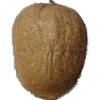

In [9]:
Kiwi = list(data_dir.glob('Kiwi/*'))
PIL.Image.open(str(Kiwi[2]))

Chargement des données:
Importer les images dans un dataframe pandas UDF

- Les images sont chargées au format binaire, pour plus de souplesse dans la façon de prétraiter les images
- charger uniquement les fichiers dont l'extension est jpg

In [10]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load("/content/drive/MyDrive/Fruits")

- Affichage des 20 premières images contenant :
  - le path de l'image

  - la date et heure de sa dernière modification : modificationtime

  - sa longueur : length

  - son contenu encodé en valeur hexadécimal: content

In [15]:
images.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/content/dri...|2021-09-12 17:26:38|  5452|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5446|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5423|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5420|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5415|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5409|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5404|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5402|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5398|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5397|[FF D8 FF E0 00 1...|
|file:/content/dri...|2021-09-12 17:26:38|  5386|[FF D8 FF E0 00 1...|
|file:

In [11]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(10,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+----------------------------------------------------+------+
|path                                                |label |
+----------------------------------------------------+------+
|file:/content/drive/MyDrive/Fruits/Orange/1_100.jpg |Orange|
|file:/content/drive/MyDrive/Fruits/Orange/17_100.jpg|Orange|
|file:/content/drive/MyDrive/Fruits/Orange/0_100.jpg |Orange|
|file:/content/drive/MyDrive/Fruits/Orange/19_100.jpg|Orange|
|file:/content/drive/MyDrive/Fruits/Orange/18_100.jpg|Orange|
|file:/content/drive/MyDrive/Fruits/Orange/11_100.jpg|Orange|
|file:/content/drive/MyDrive/Fruits/Orange/14_100.jpg|Orange|
|file:/content/drive/MyDrive/Fruits/Orange/16_100.jpg|Orange|
|file:/content/drive/MyDrive/Fruits/Orange/13_100.jpg|Orange|
|file:/content/drive/MyDrive/Fruits/Orange/10_

**Préparation du modèle :**

- Nous chargeons le modèle MobileNetV2 avec les poids précalculés issus d'imagenet et en spécifiant le format de nos images en entrée

Nous créons un nouveau modèle avec:

en entrée : l'entrée du modèle MobileNetV2

en sortie : l'avant dernière couche du modèle MobileNetV2

In [12]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

14536120/14536120 [==============================] - 0s 0us/step


In [13]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

In [14]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

**Traitement de diffusion des poids du modèle Tensorflow sur les clusters (broadcast des “weights” du modèle)**

Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids. 

Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser 
ensuite les poids aux différents workeurs.

In [15]:
brodcast_weights = sc.broadcast(new_model.get_weights())

Mettre le tout en fonction : 

In [16]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

Définition du processus de chargement des images et application de leur featurisation à travers l'utilisation de pandas UDF : 

<u>L'empilement des appels est la suivante</u> :

- Pandas UDF
  - featuriser une série d'images pd.Series
   - prétraiter une image

In [17]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)


@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


Exécuter la featurisation sur l'ensemble de notre DataFrame Spark : 

In [18]:
features_df = images.repartition(10).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [19]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [20]:
features_df.show()

+--------------------+---------------+--------------------+
|                path|          label|            features|
+--------------------+---------------+--------------------+
|file:/content/dri...|           Kiwi|[1.2349986, 7.897...|
|file:/content/dri...|           Kiwi|[0.58461845, 0.0,...|
|file:/content/dri...|           Kiwi|[0.6616302, 0.0, ...|
|file:/content/dri...|         Orange|[0.16999188, 0.0,...|
|file:/content/dri...| Apple Braeburn|[0.8586179, 0.029...|
|file:/content/dri...|Apple Pink Lady|[0.92680866, 0.17...|
|file:/content/dri...|Apple Pink Lady|[0.35648564, 0.02...|
|file:/content/dri...|Apple Pink Lady|[0.68107945, 0.04...|
|file:/content/dri...|Apple Pink Lady|[0.45530093, 0.09...|
|file:/content/dri...| Apple Braeburn|[1.2277352, 0.193...|
|file:/content/dri...|        Avocado|[1.136196, 0.0, 0...|
|file:/content/dri...|        Avocado|[0.3283423, 0.0, ...|
|file:/content/dri...|           Kiwi|[0.9042595, 0.0, ...|
|file:/content/dri...|         Orange|[0

**Réduction de dimension de type PCA en PySpark :**

In [67]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [23]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import functions as F

ud_f = F.udf(lambda r : Vectors.dense(r),VectorUDT())
features_vect = features_df.select('path', 'label', ud_f('features').alias('features_vec'))

In [24]:
features_vect.show()

+--------------------+---------------+--------------------+
|                path|          label|        features_vec|
+--------------------+---------------+--------------------+
|file:/content/dri...|           Kiwi|[1.23499858379364...|
|file:/content/dri...|           Kiwi|[0.58461844921112...|
|file:/content/dri...|           Kiwi|[0.66163021326065...|
|file:/content/dri...|         Orange|[0.16999188065528...|
|file:/content/dri...| Apple Braeburn|[0.85861790180206...|
|file:/content/dri...|Apple Pink Lady|[0.92680865526199...|
|file:/content/dri...|Apple Pink Lady|[0.35648563504219...|
|file:/content/dri...|Apple Pink Lady|[0.68107944726943...|
|file:/content/dri...|Apple Pink Lady|[0.45530092716217...|
|file:/content/dri...| Apple Braeburn|[1.22773516178131...|
|file:/content/dri...|        Avocado|[1.13619601726531...|
|file:/content/dri...|        Avocado|[0.32834228873252...|
|file:/content/dri...|           Kiwi|[0.90425950288772...|
|file:/content/dri...|         Orange|[0

In [25]:
from pyspark.ml.feature import PCA as PCAml

pca = PCAml(k=99, inputCol="features_vec", outputCol="features_pca")
model = pca.fit(features_vect)
features_df_pca = model.transform(features_vect)

In [26]:
features_df_pca.show()

+--------------------+---------------+--------------------+--------------------+
|                path|          label|        features_vec|        features_pca|
+--------------------+---------------+--------------------+--------------------+
|file:/content/dri...|           Kiwi|[1.23499858379364...|[-10.686632016764...|
|file:/content/dri...|           Kiwi|[0.58461844921112...|[-10.243911998554...|
|file:/content/dri...|           Kiwi|[0.66163021326065...|[-9.6699340682607...|
|file:/content/dri...|         Orange|[0.16999188065528...|[4.36116426087506...|
|file:/content/dri...| Apple Braeburn|[0.85861790180206...|[11.4676613729239...|
|file:/content/dri...|Apple Pink Lady|[0.92680865526199...|[8.83076313146648...|
|file:/content/dri...|Apple Pink Lady|[0.35648563504219...|[8.43162380142973...|
|file:/content/dri...|Apple Pink Lady|[0.68107944726943...|[8.99892578158169...|
|file:/content/dri...|Apple Pink Lady|[0.45530092716217...|[8.55444282789711...|
|file:/content/dri...| Apple

In [33]:
features_df_pca  = features_df_pca.drop('features_vec')

In [35]:
features_df_pca.show()

+--------------------+---------------+--------------------+
|                path|          label|        features_pca|
+--------------------+---------------+--------------------+
|file:/content/dri...|           Kiwi|[-10.686632016764...|
|file:/content/dri...|           Kiwi|[-10.243911998554...|
|file:/content/dri...|           Kiwi|[-9.6699340682607...|
|file:/content/dri...|         Orange|[4.36116426087506...|
|file:/content/dri...| Apple Braeburn|[11.4676613729239...|
|file:/content/dri...|Apple Pink Lady|[8.83076313146648...|
|file:/content/dri...|Apple Pink Lady|[8.43162380142973...|
|file:/content/dri...|Apple Pink Lady|[8.99892578158169...|
|file:/content/dri...|Apple Pink Lady|[8.55444282789711...|
|file:/content/dri...| Apple Braeburn|[11.3008982835009...|
|file:/content/dri...|        Avocado|[-9.0412517655893...|
|file:/content/dri...|        Avocado|[-9.2192814704688...|
|file:/content/dri...|           Kiwi|[-10.259077628229...|
|file:/content/dri...|         Orange|[3

In [41]:
features_df_pca

DataFrame[path: string, label: string, features_pca: vector]

In [42]:
# Enregistrement des données traitées au format "parquet" :
features_df_pca.write.mode("overwrite").parquet("/content/drive/MyDrive/Results")

In [44]:
df = pd.read_parquet("/content/drive/MyDrive/Results", engine='pyarrow')

In [49]:
df.head()

,path,label,features_pca
0,file:/content/drive/MyDrive/Fruits/Kiwi/11_100...,Kiwi,"{'type': 1, 'size': None, 'indices': None, 'va..."
1,file:/content/drive/MyDrive/Fruits/Kiwi/20_100...,Kiwi,"{'type': 1, 'size': None, 'indices': None, 'va..."
2,file:/content/drive/MyDrive/Fruits/Kiwi/21_100...,Kiwi,"{'type': 1, 'size': None, 'indices': None, 'va..."
3,file:/content/drive/MyDrive/Fruits/Orange/11_1...,Orange,"{'type': 1, 'size': None, 'indices': None, 'va..."
4,file:/content/drive/MyDrive/Fruits/Apple Braeb...,Apple Braeburn,"{'type': 1, 'size': None, 'indices': None, 'va..."


In [50]:
df.loc[0,'features_pca']

{'type': 1,
 'size': None,
 'indices': None,
 'values': array([-10.68663202,   3.09091319, -11.17232106,   4.37777771,
          7.364386  ,  -2.35481021,  -0.31548376,   0.3402496 ,
         -3.64377133,  -6.24674456,   3.94152469,  -1.57707094,
         -6.160074  ,   1.97446696,   0.83422526,  -2.30347073,
         -2.30535527,  -0.96538401,   0.29906211,   1.16412371,
         -2.63885337,   0.46138994,  -0.24972547,  -2.84180064,
          0.51493499,  -1.99645189,  -1.97228561,  -0.44397544,
         -2.28696711,   0.67156587,  -0.84320119,  -0.13415748,
          3.06950784,   0.10651831,  -0.04451883,  -0.73308704,
          0.18958885,   0.48855836,  -0.77137857,  -0.87481431,
         -0.14511362,  -0.95568303,   1.00924686,  -0.24384944,
         -0.45430624,   0.57772772,  -0.10551656,   0.38876646,
          1.31717912,   3.00735301,   0.81086173,  -0.12859406,
          0.12064917,  -2.39380904,   1.02247124,   0.24238031,
         -0.13670499,   2.26175451,   0.44814855,